# Personal Note Embedding

Author: Gabriel Stechschulte

For this exercise, the objective is to visualize the word embedding of my 1000+ personal notes that span over 1 year. My notetaking tool, Roam Research, allows me to download all of the notes on my graph as individual markdown files. Each note represents a document and my entire graph represents a corpus of documents.

Preprocessing the text data into a high quality format is of high importance for meaningful insights of the word embedding and to ensure the input into the algorithm is sensible. Since the data is coming from my local Roam Research graph, the initial data extraction will be done locally with the converted html to csv files  being stored on my Google Cloud Drive. 

Conversion of the markdown to html to csv files along with the BeautifulSoup html extraction can be found on the following public GitHub repository where the two main preprocessing and extraction files are named "convert.py" and "html_preprocess.py":

  - [Roam Research Graph Embedding](https://github.com/GStechschulte/Side_Projects/tree/main/Roam_Research_Embedding)


## A Quick Background on the Notes

The 1000+ documents consist of mainly my interests in machine learning. Therefore, the majority of the notes are related to data science, statistics, probability, and computer science—STEM related fields. However, there are also documents in regard to notes on books read, podcasts listened to and random ideas / thoughts I have had. Furthermore, in some notes there are embedded pictures and formulas and equations written in LaTeX. It's safe to say that the notes consist of a wide range of content and will be interesting to preprocess and visualize.

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib
import matplotlib.pyplot as plt
from google.colab import files, drive
from glob import glob
import os
import regex

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Reading all .csv files and converting them to dataframes
path = '/content/drive/MyDrive/CLT/roam/'
all_files = glob(os.path.join(path, '*.csv'))

file_list=[]

for file in all_files:
    df = pd.read_csv(file, usecols=['content'], index_col=None, header=0)
    file_list.append(df)

# Concat since all dataframes have the same column
big_df = pd.concat(file_list, axis=0, ignore_index=True)
big_df.dropna(how='any', inplace=True)

In [5]:
big_df

,content
0,. HSLU:. {{[[DONE]]}} Activity Effects on Slee...
1,. General Design - . Four Orders of Design:. 1...
2,. #[[Statistical Consequences of Fat Tails]]....
3,. HSLU - #Goals. {{[[DONE]]}} SA Exam. {{[[DON...
4,. . [[Kalman Filter]]. [[Hidden Markov Model]].
...,...
963,. Metadata:. Author: [[Nassim Taleb]]. #Inves...
964,. . Deliverables:. {{[[TODO]]}} Background. A ...
965,. {{[[DONE]]}} Attended HSLU classes .
967,-


In [6]:
len(big_df)

733

# Text Preprocessing

As previously mentioned, my notes have a diverse set of characters such as LaTeX symbols, hypens, em dashes, pound signs, etc. All of these needs to be removed before I can start modeling. As well, for each document, there is often the same words such as "DONE", "TODO", "Metadata", and "Tags" which also need to be removed.

## Removal of Certain and Special Characters

In [7]:
def remove_char_re(text):
  """
  Removal of special characters
  """
  text = re.sub(r"[\([{})\]]", "", text)
  text = re.sub(r"[^a-zA-Z\s]", "", text)
  text = re.sub(r"\#", "", text)
  text = re.sub(r"\$", "", text)
  text = re.sub(r"\-", "", text)
  text = re.sub(r"\:", "", text)

  return text

In [8]:
def remove_words(words):
  """
  Removal of certain words I know are specific to my notes
  """
  assert words != list

  for word in words:
    big_df['content'] = big_df['content'].str.replace('{}'.format(word), '')
  
  return big_df

In [9]:
big_df['content'] = big_df['content'].apply(remove_char_re)
big_df = remove_words(['DONE', 'done', 'TODO',
                       'Metadata', 'Tags', 'via'])

## Redundant Whitespaces and Periods

In [10]:
def remove_redundant_whitespaces(text):
  """
  When I removed excessive periods, it resulted in redundant whitespaces
  """
  text = re.sub(r'\s+'," ", text)
  text = re.sub(r'\.+'," ", text)
  return text.strip()

In [ ]:
big_df['content'] = big_df['content'].apply(remove_redundant_whitespaces)

In [11]:
big_df.dropna(inplace=True)

The text is starting to look much better now :)

# Tokenization

For the tokenization, I noticed some words consisted of one character as a result of being a noun, abbreviation, or LaTeX character. I would also like to test the word embedding with and without stop words. Two functions will be implemented to test the results of the Word2Vec embedding with and without stop words. 

In [12]:
import spacy
from spacy.lang.en import English
nltk.download('stopwords')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
def tokenizer_filter_stop_words(doc):
  """
  A function to filter the stopwords out of the document
  """
  # Tokenize the document
  tokens = wpt.tokenize(doc)
  # Convert everything to lowercase
  tokens = [t.lower() for t in tokens]
  # Filter stopwords out of document
  filtered_tokens = [token for token in tokens if token not in stop_words]

  return filtered_tokens

In [14]:
big_df['wo_stop'] = big_df['content'].apply(tokenizer_filter_stop_words)

In [15]:
# Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenizer_with_stop_words(text):
  """
  This function includes the stop words after tokenization
  """
  return [t.text.lower() for t in nlp(text)]  

In [16]:
big_df['tokens_w_stop'] = big_df['content'].apply(tokenizer_with_stop_words)

In [17]:
big_df

,content,wo_stop,tokens_w_stop
0,HSLU Activity Effects on Sleep and Type of S...,"[hslu, activity, effects, sleep, type, sleep, ...","[ , hslu, , activity, effects, on, sleep, and..."
1,General Design Four Orders of Design Graph...,"[general, design, four, orders, design, graphi...","[ , general, design, , four, orders, of, des..."
2,Statistical Consequences of Fat Tails Fat...,"[statistical, consequences, fat, tails, fat, t...","[ , statistical, consequences, of, fat, tails..."
3,HSLU Goals SA Exam Study for CS Exam Wo...,"[hslu, goals, sa, exam, study, cs, exam, worko...","[ , hslu, , goals, , sa, exam, , study, for..."
4,Kalman Filter Hidden Markov Model,"[kalman, filter, hidden, markov, model]","[ , kalman, filter, hidden, markov, model]"
...,...,...,...
963,Author Nassim Taleb Investing Wealth Wisdo...,"[author, nassim, taleb, investing, wealth, wis...","[ , author, nassim, taleb, , investing, weal..."
964,Deliverables Background A brief introductio...,"[deliverables, background, brief, introduction...","[ , deliverables, , background, a, brief, in..."
965,Attended HSLU classes,"[attended, hslu, classes]","[ , attended, hslu, classes, ]"
967,,[],[ ]


Looking at the columns "wo_stop" and "tokens_w_stop", you can tell the different between including and filtering out stop words.

# Word2Vec

In [18]:
from gensim.models import Word2Vec

## Without Stop Words

In [25]:
# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 6  # Context window size
min_word_count = 5  # Minimum word count

w2vmodel = Word2Vec(
    sentences=big_df['wo_stop'], 
    size=feature_size, 
    window=window_context, 
    min_count=min_word_count, 
    sg = 0)

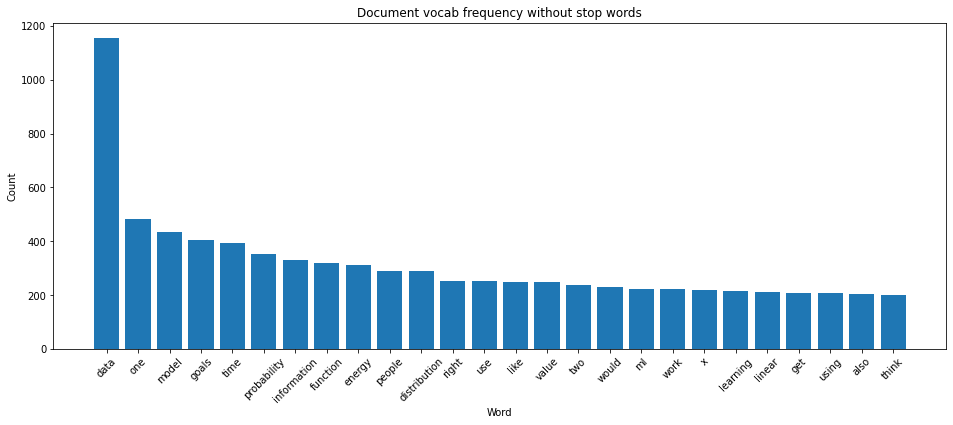

In [20]:
# Most frequent words in the w2v model
w2c = dict()
for item in w2vmodel.wv.vocab:
  w2c[item] = w2vmodel.wv.vocab[item].count

w2c_sort = dict(sorted(w2c.items(), key=lambda x: x[1], reverse=True))

word_count = dict((k, v) for k, v in w2c_sort.items() if v >= 200)

plt.figure(figsize=(16, 6))
plt.bar(word_count.keys(), word_count.values())
plt.title('Document vocab frequency without stop words')
plt.ylabel('Count')
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.show()

This is interesting to analyze and the more I think about it, the more it makes sense. Especially since some of the topics I am most interested in is "data, model, probability, information", etc. Then, we see the single "x" which I know from my notes that this is really a variable "X or x" from writing equations / formulas in LaTeX. 

In [21]:
w2vmodel.wv.index2word[250:255]

['maximum', 'events', 'projects', 'problems', 'always']

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


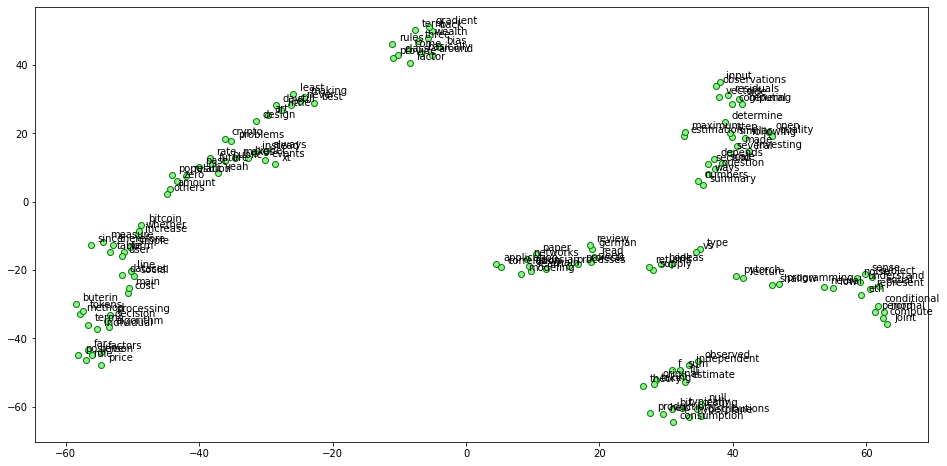

In [27]:
from sklearn.manifold import TSNE

words = w2vmodel.wv.index2word[200:350]               ## get the word forms of vocab sample
wvs = w2vmodel.wv[words]                              ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
plt.show()

Interpreting the visualization of our embedding reveals some interesting insights. In the bottom left corner, I see that the nouns "buterin", "ethereum", and "bitcoin" are in relatively the same area meaning the embedding has learned about notes taken in regard to cryptocurrency and the blockchain. 

In the cluster in the top right corner, there's the words "input", "observations", and "residuals" all relatively close together. My notes in regard to regression methods come into mind when I see this cluster. 

Looking at the bottom right corner (near the right y-axis) I see the words "conditional", "joint", and "compute". I have a fair amount of notes on probability concepts such as conditional and joint distributions. Then, the compute comes from the fact that I have taken some notes in regard to how computationally expensive it is to *compute* the joint distribution when many variables are involved. 

However, the visualized embedding doesn't always make sense. For example, the bottom left cluster (-55, -45) has "far", "factors", and "price" all with a very close distance to each other. This makes no particular sense to me. Another interesting aspect is the distinct distances from cluster to cluster. You could argue that their is anywhere from 6 to 8 clusters.

Below I will use the same model, but input a different vocabulary size, number of components, and the all important perplexity parameter. 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


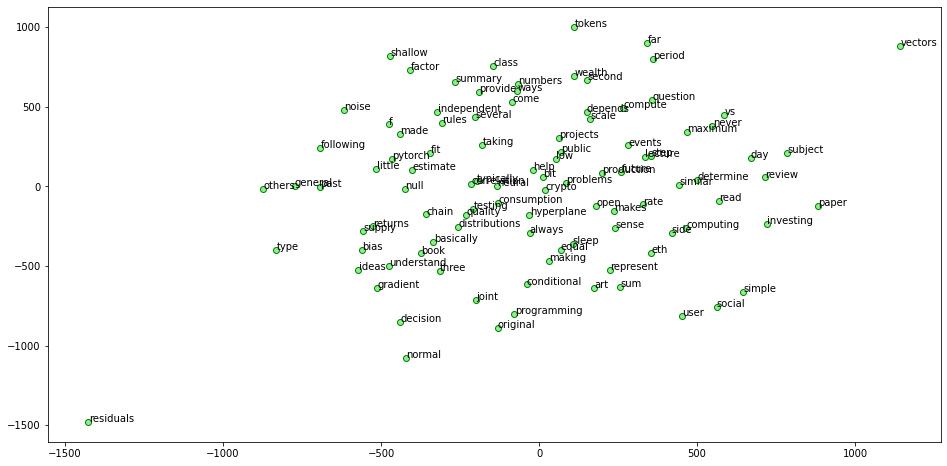

In [42]:
# Different size of vocab sample
words = w2vmodel.wv.index2word[250:350]               ## get the word forms of vocab sample
wvs = w2vmodel.wv[words]                              ## get embeddings of word forms

# Different number of components, iterations, and perplexity
tsne = TSNE(n_components=3, random_state=0, n_iter=8000, perplexity=10)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
plt.show()

For one, using a smaller vocobulary sample makes it easier to interpret. Secondly, the number of components and perplexity parameter has a significant effect on the embedding space. In this space, we see one giant cluster with two outliers; "residuals" and "vectors". However, when looking at the words, I can't necessarily distinguish any meangingful semantic similarity. 

In [44]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn=100)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=3, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


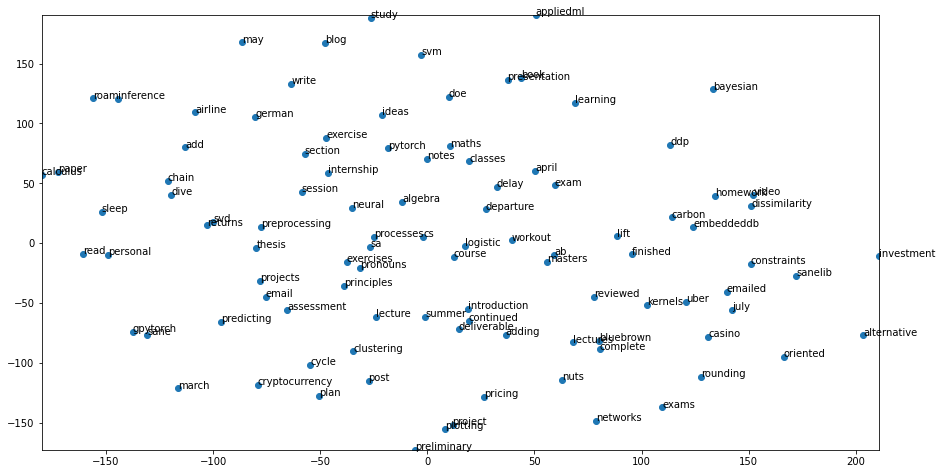

In [48]:
display_closestwords_tsnescatterplot(w2vmodel, 'bayesian', 100) 

The 100 most similar words to "bayesian" is an interesting result because I notice a lot of words that without prior knowledge of the notes, one would assume the model is giving bizarre results. Nonetheless, some words, in my opinion aren't similar, whereas some words are more similar. For example, words that are similar to "bayesian" that wouldn't be recognized by somebody else is the words "summer" and "casino". I believe these words show up because over this past summer, I was working on personal projects related to bayesian methods and was tagging my *Summer Projects* note. Then, the word casino appears because I am currently working on a project for the casino of Luzern to detect problematic gamblers and we are primarily interest in applying bayesian methods of inference to solve the problem–this resulting in a significant amount of "bayesian" words associated with this document.

## With Stop Words

*Here I will not commentate each visualization. Rather it was an experiment to look at the differences between the embedding with and without stop words. 

In [36]:
# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count

w2vmodel_with_stop = Word2Vec(
    sentences=big_df['tokens_w_stop'], 
    size=feature_size, 
    window=window_context, 
    min_count=min_word_count, 
    sg = 0)

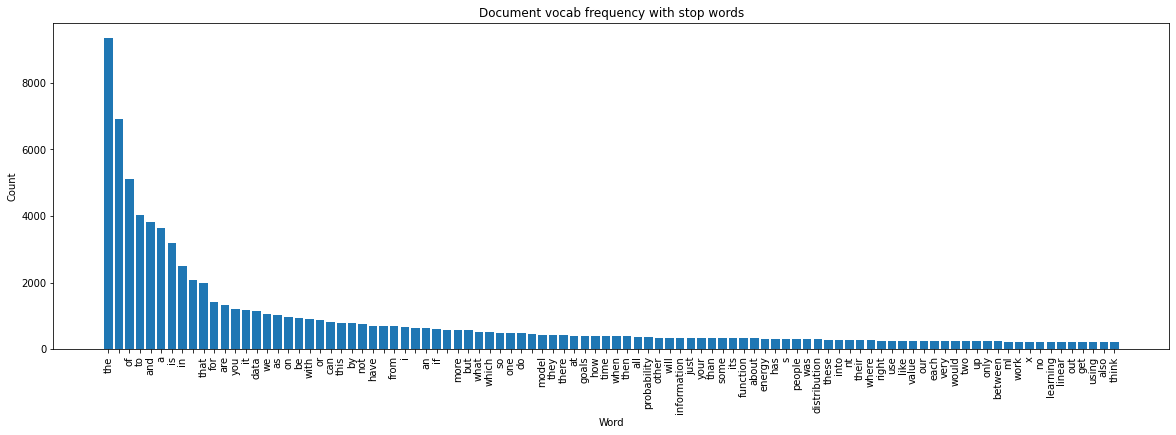

In [37]:
# Most frequent words in the w2v model with stop words
w2c = dict()
for item in w2vmodel_with_stop.wv.vocab:
  w2c[item] = w2vmodel_with_stop.wv.vocab[item].count

w2c_sort = dict(sorted(w2c.items(), key=lambda x: x[1], reverse=True))

word_count = dict((k, v) for k, v in w2c_sort.items() if v >= 200)

plt.figure(figsize=(20, 6))
plt.bar(word_count.keys(), word_count.values())
plt.title('Document vocab frequency with stop words')
plt.ylabel('Count')
plt.xlabel('Word')
plt.xticks(rotation=90)
plt.show()

As expected, stop words represent the highest count and may result in a distortation of signal and noise.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


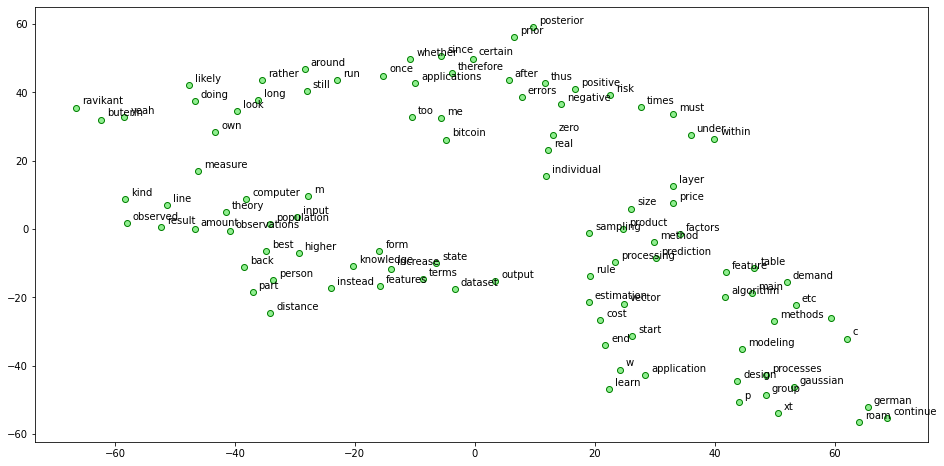

In [40]:
words = w2vmodel_with_stop.wv.index2word[250:350]               ## get the word forms of voculary sample
wvs = w2vmodel_with_stop.wv[words]                              ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=10)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


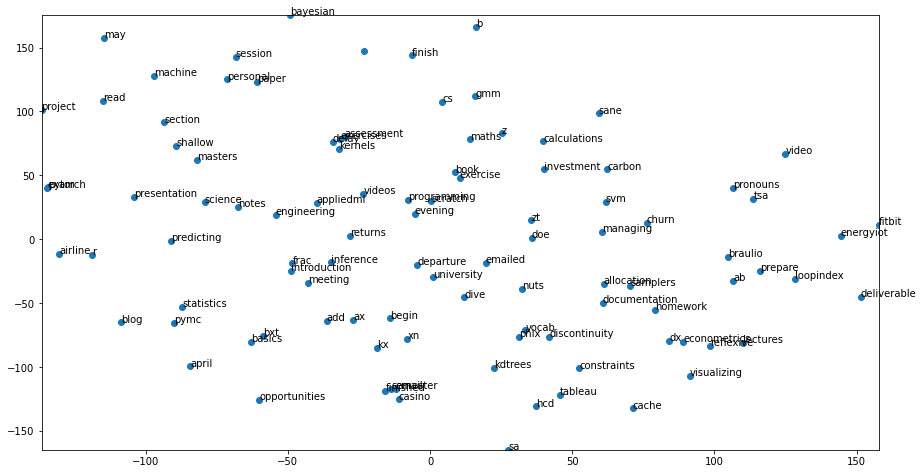

In [49]:
display_closestwords_tsnescatterplot(w2vmodel_with_stop, 'programming', 100) 

# Comparison to Pretrained Embedding

In this section, the learned embeddings of my model will be compared a pretrained embedding space of GloVe.

In [ ]:
import gensim.downloader as api
glove_vectors = api.load("glove-wiki-gigaword-100")   

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# Similar Words
similar_words_word2vec = {
    search_term:
    [item[0] for item in w2vmodel.wv.most_similar([search_term], topn=5)]
    for search_term in ['statistics', 'probability', 'data', 'computer']
}

similar_words_word2vec_with_stop = {
    search_term:
    [item[0] for item in w2vmodel_with_stop.wv.most_similar([search_term], topn=5)]
    for search_term in ['statistics', 'probability', 'data', 'computer']
}

similar_words_glove = {
    search_term:
    [item[0] for item in glove_vectors.most_similar([search_term], topn=5)]
    for search_term in ['statistics', 'probability', 'data', 'computer']
}

In [ ]:
print('word2vec          ', similar_words_word2vec)
print('word2vec_with_stop', similar_words_word2vec_with_stop)
print('GloVe             ', similar_words_glove)

word2vec           {'statistics': ['code', 'modeling', 'learn', 'algorithms', 'science'], 'probability': ['given', 'distribution', 'random', 'value', 'conditional'], 'data': ['processing', 'key', 'new', 'etc', 'art'], 'computer': ['start', 'first', 'short', 'information', 'etc']}
word2vec_with_stop {'statistics': ['science', 'research', 'group', 'measuring', 'gmm'], 'probability': ['distribution', 'the', 'value', 'a', 'variable'], 'data': ['efficiency', 'for', 'consumption', 'latent', 'analysis'], 'computer': ['create', 'put', 'crypto', 'today', 'assets']}
GloVe              {'statistics': ['figures', 'report', 'data', 'statistic', 'bureau'], 'probability': ['probabilities', 'correlation', 'variables', 'variance', 'likelihood'], 'data': ['information', 'analysis', 'tracking', 'database', 'system'], 'computer': ['computers', 'software', 'technology', 'pc', 'hardware']}


Looking at the differences between my trained embedding and the pre-trained embedding I can see where more data in the pre-trained model helps. However, with embedding I can also notice more specifics related to the I have taken notes on the concepts. 

For example, the most similar words for "statistics" focuses on "science", "modeling", and "algorithms" which is the areas I focus on learning and taking notes in regard to. Whereas the out-of-the-box model presents more common general takes on statistics such as "figures", "data", and "bureau".

As well, I was surprised to see that some words did not make it on to my embedding space for "probability". In particular, "variable" should have most definitely made it onto the embedding without stop words. Though, it managed to make it onto the most similar of the embedding space with stop words. 

In [ ]:
# Most frequent words similarity
similar_words_word2vec = {
    search_term:
    [item[0] for item in w2vmodel.wv.most_similar([search_term], topn=5)]
    for search_term in ['data', 'one', 'model', 'goals', 'time', 
                        'probability', 'information', 'function', 'energy']
}

similar_words_glove = {
    search_term:
    [item[0] for item in glove_vectors.most_similar([search_term], topn=5)]
    for search_term in ['data', 'one', 'model', 'goals', 'time', 
                        'probability', 'information', 'function', 'energy']
}

In [ ]:
print('word2vec          ', similar_words_word2vec)
print('GloVe             ', similar_words_glove)

word2vec           {'data': ['processing', 'key', 'new', 'etc', 'art'], 'one': ['would', 'like', 'number', 'get', 'also'], 'model': ['ie', 'using', 'variance', 'used', 'features'], 'goals': ['math', 'ml', 'stats', 'gp', 'ds'], 'time': ['number', 'one', 'mean', 'point', 'value'], 'probability': ['given', 'distribution', 'random', 'value', 'conditional'], 'information': ['new', 'rules', 'etc', 'start', 'individual'], 'function': ['parameters', 'parameter', 'ie', 'using', 'likelihood'], 'energy': ['consumption', 'iso', 'efficiency', 'management', 'savings']}
GloVe              {'data': ['information', 'analysis', 'tracking', 'database', 'system'], 'one': ['only', 'another', 'this', 'same', 'two'], 'model': ['models', 'design', 'concept', 'prototype', 'introduced'], 'goals': ['goal', 'scored', 'scoring', 'scorer', 'score'], 'time': ['when', 'this', 'before', 'but', 'only'], 'probability': ['probabilities', 'correlation', 'variables', 'variance', 'likelihood'], 'information': ['data', 'know

Above shows the top 5 most similar words to the 9 most frequent words in the vocabulary of my corpus of documents. For the word data, I believe the most similar words of the GloVe pre-trained model do a better job of displaying the semantics. Whereas, for my model, the majority of the most similar words don't even make sense, i.e., "art", "etc", and "new". 

Though, moving to the word "goals", my embedding does a better job with displaying the most similar words. This is because I had a goal document with a host of goals related to math, ml, stats, and data science (ds). Therefore, the embedding has learned this. The pre-trained model thinks goals has to do with sports whereas my embedding learned that goals is related to my personal knowledge. 

Overall, without knowledge of what my personal notes consisted of and the style of writing, one would likely say that the pre-trained model does a better job of capturing the semantics. However, if you take into account the style of note taking and what the objective was when taking the notes, then my embedding space may make more sense. This insight kind of makes everything context dependent. Sometimes the pre-trained model is "better" and sometimes my embedding space does a "better" job.

# Summary

Overall, this project was very interesting to experiment with different variations of models, comparisons to pre-trained models, and to practice text preprocessing. One major takeway I have is that the results of the models are very context (or one can say industry) specific. Without prior knowledge about how I take my notes, the objectives behind the note taking, and the content of the notes, it would be easy to mistake the pre-trained model as capturing the semantic space better. However, with prior knowledge about the content of the notes, the results make sense—though not always.

In particular, my interest and content in regard to notes taken on the word "statistics" focuses on very specific aspects of statistics such as "science", "modeling", and "algorithms". Whereas the GloVe model has a more generalized semantic view of statistics. Though, sometimes the GloVe model due to its larger training data and generalized semantic space does make more sense with the outputs of similar words. I case of this is for the word "probability". My embedding, surprisingly, doesn't capture "variable" as a similar word.

In regard to the most similar words for the most frequently occuring words the *context dependency* is still relevant. The GloVe model's output of most similar words for "data" makes more sense than my embedding. I believe this is due to lack of data on the word data—I don't have much content written on "data". Then, for the word "goals" my embedding space captures explicitly what I write about in regard to goals—personally defined goals which happen to be the most similar words. The GloVe model relates "goals" to a sports context.

In conclusion, pre-trained embeddings seem to be better with general embedding spaces due to the large training data on *general* vocabulary. However, when it comes to specific contexts or industry language, pre-trained models often underperform relative to the embeddings trained on specific content and language. Furthermore, having background knowledge regarding the problem being addressed / solved can help to interpret the results outputed by the models.


